# Import packages

In [45]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

# Load data

In [59]:
data_file_name = 'dataset.xlsx'
data_dir_path = '.'
data_file_path = os.path.join(data_dir_path, data_file_name)

# Load 'data' spreadsheet
df = pd.read_excel(open(data_file_path, 'rb'), sheetname='data', header=1)

# print(df.head())
# print(df.columns)

        Date    KOSPI  KOSDAQ  Average_Temperature  Lowest_Temperature  \
0 2016-01-04  1918.76  677.79                 10.4                 7.6   
1 2016-01-05  1930.53  684.07                  5.3                 3.2   
2 2016-01-06  1925.43  687.27                  4.8                 1.8   
3 2016-01-07  1904.33  679.66                  3.9                 1.1   
4 2016-01-08  1917.62  682.56                  2.5                -0.5   

   Highest_temperature  Precipitation  Average_Wind_Speed  \
0                 15.2            0.0                 2.7   
1                  8.1            0.2                 3.1   
2                  9.9            0.0                 2.9   
3                  8.5            0.0                 2.7   
4                  6.9            0.0                 2.9   

   Average_Relative_humidity  Daylight_Hours  Cloud_Cover  Duration_of_Fog  \
0                       46.3             8.6          0.8              0.0   
1                       40.9    

# 1) Preprocessing - fill in missing values

# Defin a function

In [50]:
def fill_in_missing_data(data, window_size):
    num_of_data = len(data)
    indices = np.where(np.isnan(data))[0]

    for i in indices:
        values = []
        distances = []
        for j in range(1,window_size+1):
            if i-j >= 0 and not np.isnan(data[i-j]):
                values.append(data[i-j])
                distances.append(j)
            if i+j < num_of_data and not np.isnan(data[i+j]):
                values.append(data[i+j])
                distances.append(j)

        values = np.array(values)
        distances = np.array(distances)
        inverse_distances = 1.0 / distances
        weights = inverse_distances / np.sum(inverse_distances)
        filling_value = np.sum(np.multiply(values, weights))
        data[i] = filling_value
    return data

def test_fill_in_missing_data(data, window_size):
    modified_data = fill_in_missing_data(np.copy(data), 3)
    plt.plot(modified_data)
    plt.show()
#     data[np.where(np.isnan(data))] = 0
#     plt.plot(data)
#     plt.ylim(1800, 2100)
#     plt.show()
    

# Fill in missing values - Kospi & Kosdaq

In [51]:
kospi = df['KOSPI']
kosdaq = df['KOSDAQ']

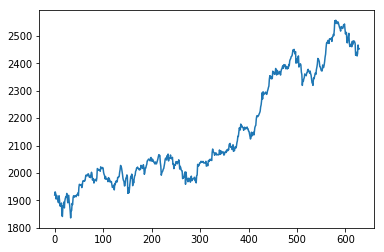

In [52]:
test_fill_in_missing_data(np.copy(kospi),3)

In [55]:
# fill in missing values
window_size = 3
df['KOSPI'] = fill_in_missing_data(np.copy(kospi), window_size)
df['KOSDAQ'] = fill_in_missing_data(np.copy(kosdaq), window_size)

# 2) Preprocessing - classify 'Revenue' for classification

# Add 'Rate' variable to see how 'Revenue has changed

In [70]:
initial_revenue = 1200000.0
revenue = np.array(df['Revenue'])
prev_revenue = np.concatenate(([initial_revenue], revenue[:-1])).astype(float)
rate = (revenue - prev_revenue) / prev_revenue
df['Increasing_Rate'] = rate

# Classify 'Revenue'

In [71]:
rate = df['Increasing_Rate']
df['Rate_Class'] = np.where(rate > 0.6, 'very high', 
                            (np.where(rate > 0.3, 'high',
                                     np.where(rate > -0.3, 'moderate',
                                             np.where(rate > -0.6, 'low', 'very low')))))

# 3) Preprocessing - scale using min/max

# Define a function

In [72]:
def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

# Scale variables using min/max values - all variables but 'Date' & 'Rate_Class'

In [73]:
columns = [x for x in df.columns if x not in ['Date', 'Rate_Class']]
df_scaled = df.copy()
df_scaled[columns] = df_scaled[columns].apply(MinMaxScaler, axis=0)
df_scaled['Date'] = df['Date']
df_scaled['Rate_Class'] = df['Rate_Class']

# Final dataset - Done with preprocessing

In [66]:
print(df_scaled.head())

      KOSPI    KOSDAQ  Average_Temperature  Lowest_Temperature  \
0  0.115513  0.459785             0.388889            0.438692   
1  0.131799  0.487909             0.239766            0.318801   
2  0.124742  0.502239             0.225146            0.280654   
3  0.095546  0.468159             0.198830            0.261580   
4  0.113935  0.481146             0.157895            0.217984   

   Highest_temperature  Precipitation  Average_Wind_Speed  \
0             0.412281       0.000000            0.010223   
1             0.204678       0.001675            0.011738   
2             0.257310       0.000000            0.010981   
3             0.216374       0.000000            0.010223   
4             0.169591       0.000000            0.010981   

   Average_Relative_humidity  Daylight_Hours  Cloud_Cover  Duration_of_Fog  \
0                   0.461224        0.089304     0.061538              0.0   
1                   0.406122        0.000000     0.538462              0.0   
2 

# Regression Models

# 1) LSTM 

# Import additional packages 

In [ ]:
import tensorflow as tf

# Assign hyperparameters 

In [64]:
lstm_variable_list = df_scaled.columns
seq_len = 5
data_dim = len(variable_list)
output_dim = 1
hidden_dim = 10
iterations = 2000

In [20]:
dataX = []
dataY = []
for i in range(df_subset_scaled.shape[0] - seq_len):
    _x = df_subset_scaled.loc[i:i+seq_len-1, variable_list].values
    _y = df_subset_scaled.loc[i+seq_len, target_variable].values
    print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

(array([[0.38888889, 0.25583387],
       [0.23976608, 0.19160779],
       [0.2251462 , 0.20231214],
       [0.19883041, 0.18732605],
       [0.15789474, 0.09526868]]), '->', array([0.23442518]))
(array([[0.23976608, 0.19160779],
       [0.2251462 , 0.20231214],
       [0.19883041, 0.18732605],
       [0.15789474, 0.09526868],
       [0.19590643, 0.23442518]]), '->', array([0.13808606]))
(array([[0.2251462 , 0.20231214],
       [0.19883041, 0.18732605],
       [0.15789474, 0.09526868],
       [0.19590643, 0.23442518],
       [0.21637427, 0.13808606]]), '->', array([0.4485121]))
(array([[0.19883041, 0.18732605],
       [0.15789474, 0.09526868],
       [0.19590643, 0.23442518],
       [0.21637427, 0.13808606],
       [0.15789474, 0.4485121 ]]), '->', array([0.57696425]))
(array([[0.15789474, 0.09526868],
       [0.19590643, 0.23442518],
       [0.21637427, 0.13808606],
       [0.15789474, 0.4485121 ],
       [0.12865497, 0.57696425]]), '->', array([0.26653821]))
(array([[0.19590643, 0.234

       [0.3625731 , 0.03832156]]), '->', array([0.06679512]))
(array([[0.33625731, 0.26910726],
       [0.32163743, 0.16634554],
       [0.30116959, 0.07171912],
       [0.3625731 , 0.03832156],
       [0.42982456, 0.06679512]]), '->', array([0.07171912]))
(array([[0.32163743, 0.16634554],
       [0.30116959, 0.07171912],
       [0.3625731 , 0.03832156],
       [0.42982456, 0.06679512],
       [0.47368421, 0.07171912]]), '->', array([0.04354528]))
(array([[0.30116959, 0.07171912],
       [0.3625731 , 0.03832156],
       [0.42982456, 0.06679512],
       [0.47368421, 0.07171912],
       [0.51754386, 0.04354528]]), '->', array([0.13337615]))
(array([[0.3625731 , 0.03832156],
       [0.42982456, 0.06679512],
       [0.47368421, 0.07171912],
       [0.51754386, 0.04354528],
       [0.55555555, 0.13337615]]), '->', array([0.10447442]))
(array([[0.42982456, 0.06679512],
       [0.47368421, 0.07171912],
       [0.51754386, 0.04354528],
       [0.55555555, 0.13337615],
       [0.52631579, 0.104

(array([[0.68421052, 0.67030614],
       [0.69005848, 0.42967245],
       [0.69883041, 0.32926568],
       [0.69590643, 0.31642047],
       [0.65497076, 0.14964676]]), '->', array([0.01584243]))
(array([[0.69005848, 0.42967245],
       [0.69883041, 0.32926568],
       [0.69590643, 0.31642047],
       [0.65497076, 0.14964676],
       [0.64912281, 0.01584243]]), '->', array([0.07899807]))
(array([[0.69883041, 0.32926568],
       [0.69590643, 0.31642047],
       [0.65497076, 0.14964676],
       [0.64912281, 0.01584243],
       [0.73099415, 0.07899807]]), '->', array([0.22457718]))
(array([[0.69590643, 0.31642047],
       [0.65497076, 0.14964676],
       [0.64912281, 0.01584243],
       [0.73099415, 0.07899807],
       [0.75730994, 0.22457718]]), '->', array([0.19781631]))
(array([[0.65497076, 0.14964676],
       [0.64912281, 0.01584243],
       [0.73099415, 0.07899807],
       [0.75730994, 0.22457718],
       [0.69883041, 0.19781631]]), '->', array([0.18629844]))
(array([[0.64912281, 0.01

       [0.84210526, 0.21451509]]), '->', array([0.15242989]))
(array([[0.83333333, 0.004924  ],
       [0.80701754, 0.23121387],
       [0.78654971, 0.38835367],
       [0.84210526, 0.21451509],
       [0.85087719, 0.15242989]]), '->', array([0.11368015]))
(array([[0.80701754, 0.23121387],
       [0.78654971, 0.38835367],
       [0.84210526, 0.21451509],
       [0.85087719, 0.15242989],
       [0.79824561, 0.11368015]]), '->', array([0.11918219]))
(array([[0.78654971, 0.38835367],
       [0.84210526, 0.21451509],
       [0.85087719, 0.15242989],
       [0.79824561, 0.11368015],
       [0.75730994, 0.11918219]]), '->', array([0.29308499]))
(array([[0.84210526, 0.21451509],
       [0.85087719, 0.15242989],
       [0.79824561, 0.11368015],
       [0.75730994, 0.11918219],
       [0.79824561, 0.29308499]]), '->', array([0.45472062]))
(array([[0.85087719, 0.15242989],
       [0.79824561, 0.11368015],
       [0.75730994, 0.11918219],
       [0.79824561, 0.29308499],
       [0.82163742, 0.454

       [0.84210526, 0.19460501]]), '->', array([0.23463926]))
(array([[0.70760234, 0.36202098],
       [0.74561403, 0.01370156],
       [0.8245614 , 0.58702633],
       [0.84210526, 0.19460501],
       [0.70467836, 0.23463926]]), '->', array([0.01948191]))
(array([[0.74561403, 0.01370156],
       [0.8245614 , 0.58702633],
       [0.84210526, 0.19460501],
       [0.70467836, 0.23463926],
       [0.79824561, 0.01948191]]), '->', array([0.81631342]))
(array([[0.8245614 , 0.58702633],
       [0.84210526, 0.19460501],
       [0.70467836, 0.23463926],
       [0.79824561, 0.01948191],
       [0.83333333, 0.81631342]]), '->', array([0.28880325]))
(array([[0.84210526, 0.19460501],
       [0.70467836, 0.23463926],
       [0.79824561, 0.01948191],
       [0.83333333, 0.81631342],
       [0.8245614 , 0.28880325]]), '->', array([0.14044102]))
(array([[0.70467836, 0.23463926],
       [0.79824561, 0.01948191],
       [0.83333333, 0.81631342],
       [0.8245614 , 0.28880325],
       [0.83333333, 0.140

       [0.36842105, 0.32648255]]), '->', array([0.12459859]))
(array([[0.5497076 , 0.59280668],
       [0.50292398, 0.0605866 ],
       [0.4502924 , 0.10169129],
       [0.36842105, 0.32648255],
       [0.40643275, 0.12459859]]), '->', array([0.10982659]))
(array([[0.50292398, 0.0605866 ],
       [0.4502924 , 0.10169129],
       [0.36842105, 0.32648255],
       [0.40643275, 0.12459859],
       [0.45906433, 0.10982659]]), '->', array([0.04450011]))
(array([[0.4502924 , 0.10169129],
       [0.36842105, 0.32648255],
       [0.40643275, 0.12459859],
       [0.45906433, 0.10982659],
       [0.5116959 , 0.04450011]]), '->', array([0.00256904]))
(array([[0.36842105, 0.32648255],
       [0.40643275, 0.12459859],
       [0.45906433, 0.10982659],
       [0.5116959 , 0.04450011],
       [0.58187134, 0.00256904]]), '->', array([0.00107043]))
(array([[0.40643275, 0.12459859],
       [0.45906433, 0.10982659],
       [0.5116959 , 0.04450011],
       [0.58187134, 0.00256904],
       [0.52923976, 0.001

(array([[0.21052632, 0.00428174],
       [0.19298246, 0.03746521],
       [0.15789474, 0.00192678],
       [0.15497076, 0.02462   ],
       [0.3625731 , 0.18946692]]), '->', array([0.71076857]))
(array([[0.19298246, 0.03746521],
       [0.15789474, 0.00192678],
       [0.15497076, 0.02462   ],
       [0.3625731 , 0.18946692],
       [0.31578947, 0.71076857]]), '->', array([0.50289017]))
(array([[0.15789474, 0.00192678],
       [0.15497076, 0.02462   ],
       [0.3625731 , 0.18946692],
       [0.31578947, 0.71076857],
       [0.32163743, 0.50289017]]), '->', array([0.09441233]))
(array([[0.15497076, 0.02462   ],
       [0.3625731 , 0.18946692],
       [0.31578947, 0.71076857],
       [0.32163743, 0.50289017],
       [0.3128655 , 0.09441233]]), '->', array([0.33290516]))
(array([[0.3625731 , 0.18946692],
       [0.31578947, 0.71076857],
       [0.32163743, 0.50289017],
       [0.3128655 , 0.09441233],
       [0.30409357, 0.33290516]]), '->', array([0.04795547]))
(array([[0.31578947, 0.71

       [0.1754386 , 0.5384286 ]]), '->', array([0.02462]))
(array([[0.28070175, 0.2716763 ],
       [0.36842105, 0.45215157],
       [0.29239766, 0.03339756],
       [0.1754386 , 0.5384286 ],
       [0.16959064, 0.02462   ]]), '->', array([0.01605652]))
(array([[0.36842105, 0.45215157],
       [0.29239766, 0.03339756],
       [0.1754386 , 0.5384286 ],
       [0.16959064, 0.02462   ],
       [0.28654971, 0.01605652]]), '->', array([0.31342325]))
(array([[0.29239766, 0.03339756],
       [0.1754386 , 0.5384286 ],
       [0.16959064, 0.02462   ],
       [0.28654971, 0.01605652],
       [0.33625731, 0.31342325]]), '->', array([0.13466067]))
(array([[0.1754386 , 0.5384286 ],
       [0.16959064, 0.02462   ],
       [0.28654971, 0.01605652],
       [0.33625731, 0.31342325],
       [0.38596491, 0.13466067]]), '->', array([0.14686363]))
(array([[0.16959064, 0.02462   ],
       [0.28654971, 0.01605652],
       [0.33625731, 0.31342325],
       [0.38596491, 0.13466067],
       [0.40350877, 0.146863

(array([[0.52631579, 0.01991008],
       [0.53216374, 0.30186256],
       [0.53801169, 0.15457076],
       [0.49415205, 0.11667737],
       [0.55555555, 0.1701991 ]]), '->', array([0.05031043]))
(array([[0.53216374, 0.30186256],
       [0.53801169, 0.15457076],
       [0.49415205, 0.11667737],
       [0.55555555, 0.1701991 ],
       [0.5994152 , 0.05031043]]), '->', array([0.02569043]))
(array([[0.53801169, 0.15457076],
       [0.49415205, 0.11667737],
       [0.55555555, 0.1701991 ],
       [0.5994152 , 0.05031043],
       [0.50584795, 0.02569043]]), '->', array([0.32862342]))
(array([[0.49415205, 0.11667737],
       [0.55555555, 0.1701991 ],
       [0.5994152 , 0.05031043],
       [0.50584795, 0.02569043],
       [0.50877193, 0.32862342]]), '->', array([0.1145365]))
(array([[0.55555555, 0.1701991 ],
       [0.5994152 , 0.05031043],
       [0.50584795, 0.02569043],
       [0.50877193, 0.32862342],
       [0.54093567, 0.1145365 ]]), '->', array([0.0588739]))
(array([[0.5994152 , 0.0503

       [0.88011696, 0.19503318]]), '->', array([0.04388782]))
(array([[0.8245614 , 0.18090345],
       [0.8625731 , 0.20916292],
       [0.87134503, 0.49561122],
       [0.88011696, 0.19503318],
       [0.85087719, 0.04388782]]), '->', array([0.0310426]))
(array([[0.8625731 , 0.20916292],
       [0.87134503, 0.49561122],
       [0.88011696, 0.19503318],
       [0.85087719, 0.04388782],
       [0.88888889, 0.0310426 ]]), '->', array([0.05031043]))
(array([[0.87134503, 0.49561122],
       [0.88011696, 0.19503318],
       [0.85087719, 0.04388782],
       [0.88888889, 0.0310426 ],
       [0.8625731 , 0.05031043]]), '->', array([0.09526868]))
(array([[0.88011696, 0.19503318],
       [0.85087719, 0.04388782],
       [0.88888889, 0.0310426 ],
       [0.8625731 , 0.05031043],
       [0.9122807 , 0.09526868]]), '->', array([0.09612503]))
(array([[0.85087719, 0.04388782],
       [0.88888889, 0.0310426 ],
       [0.8625731 , 0.05031043],
       [0.9122807 , 0.09526868],
       [0.90058479, 0.0961

       [0.70467836, 0.0768572 ]]), '->', array([0.1046885]))
(array([[0.78362573, 0.10233355],
       [0.76315789, 0.54485121],
       [0.68128655, 0.15457076],
       [0.70467836, 0.0768572 ],
       [0.62280702, 0.1046885 ]]), '->', array([0.03746521]))
(array([[0.76315789, 0.54485121],
       [0.68128655, 0.15457076],
       [0.70467836, 0.0768572 ],
       [0.62280702, 0.1046885 ],
       [0.67543859, 0.03746521]]), '->', array([0.13808606]))
(array([[0.68128655, 0.15457076],
       [0.70467836, 0.0768572 ],
       [0.62280702, 0.1046885 ],
       [0.67543859, 0.03746521],
       [0.62573099, 0.13808606]]), '->', array([0.11025476]))
(array([[0.70467836, 0.0768572 ],
       [0.62280702, 0.1046885 ],
       [0.67543859, 0.03746521],
       [0.62573099, 0.13808606],
       [0.70467836, 0.11025476]]), '->', array([0.61764076]))
(array([[0.62280702, 0.1046885 ],
       [0.67543859, 0.03746521],
       [0.62573099, 0.13808606],
       [0.70467836, 0.11025476],
       [0.72807017, 0.6176

(array([[0.38888889, 0.07385999],
       [0.28947368, 0.13594519],
       [0.26023392, 0.2061657 ],
       [0.33333333, 0.17919075],
       [0.35672515, 0.03532434]]), '->', array([0.05159495]))
(array([[0.28947368, 0.13594519],
       [0.26023392, 0.2061657 ],
       [0.33333333, 0.17919075],
       [0.35672515, 0.03532434],
       [0.24853801, 0.05159495]]), '->', array([0.06957825]))
(array([[0.26023392, 0.2061657 ],
       [0.33333333, 0.17919075],
       [0.35672515, 0.03532434],
       [0.24853801, 0.05159495],
       [0.25438596, 0.06957825]]), '->', array([0.09526868]))
(array([[0.33333333, 0.17919075],
       [0.35672515, 0.03532434],
       [0.24853801, 0.05159495],
       [0.25438596, 0.06957825],
       [0.29532164, 0.09526868]]), '->', array([0.04131878]))
(array([[0.35672515, 0.03532434],
       [0.24853801, 0.05159495],
       [0.25438596, 0.06957825],
       [0.29532164, 0.09526868],
       [0.44444444, 0.04131878]]), '->', array([0.20017127]))
(array([[0.24853801, 0.05

(?, 10)
Step 0 - loss : 31.8036003113
Step 1 - loss : 14.4664449692
Step 2 - loss : 22.1729717255
Step 3 - loss : 21.5671615601
Step 4 - loss : 16.9907226562
Step 5 - loss : 14.589299202
Step 6 - loss : 14.7747240067
Step 7 - loss : 15.9404392242
Step 8 - loss : 16.7437839508
Step 9 - loss : 16.7280502319
Step 10 - loss : 16.0881175995
Step 11 - loss : 15.255818367
Step 12 - loss : 14.6106672287
Step 13 - loss : 14.3475379944
Step 14 - loss : 14.4548091888
Step 15 - loss : 14.7675981522
Step 16 - loss : 15.069562912
Step 17 - loss : 15.2002754211
Step 18 - loss : 15.1157054901
Step 19 - loss : 14.8791046143
Step 20 - loss : 14.6049232483
Step 21 - loss : 14.3968057632
Step 22 - loss : 14.3085346222
Step 23 - loss : 14.3358335495
Step 24 - loss : 14.4323253632
Step 25 - loss : 14.5367860794
Step 26 - loss : 14.5990495682
Step 27 - loss : 14.5958404541
Step 28 - loss : 14.533575058
Step 29 - loss : 14.4401664734
Step 30 - loss : 14.3509187698
Step 31 - loss : 14.2942523956
Step 32 - loss

Step 285 - loss : 14.2037200928
Step 286 - loss : 14.2034082413
Step 287 - loss : 14.2030906677
Step 288 - loss : 14.2027702332
Step 289 - loss : 14.2024517059
Step 290 - loss : 14.2021303177
Step 291 - loss : 14.2018041611
Step 292 - loss : 14.2014770508
Step 293 - loss : 14.2011508942
Step 294 - loss : 14.2008190155
Step 295 - loss : 14.2004871368
Step 296 - loss : 14.2001495361
Step 297 - loss : 14.1998100281
Step 298 - loss : 14.19947052
Step 299 - loss : 14.1991291046
Step 300 - loss : 14.1987819672
Step 301 - loss : 14.1984357834
Step 302 - loss : 14.1980838776
Step 303 - loss : 14.1977291107
Step 304 - loss : 14.1973743439
Step 305 - loss : 14.1970129013
Step 306 - loss : 14.1966485977
Step 307 - loss : 14.1962842941
Step 308 - loss : 14.1959171295
Step 309 - loss : 14.1955471039
Step 310 - loss : 14.1951713562
Step 311 - loss : 14.1947917938
Step 312 - loss : 14.1944112778
Step 313 - loss : 14.1940231323
Step 314 - loss : 14.1936359406
Step 315 - loss : 14.1932411194
Step 316 -

Step 570 - loss : 13.2374897003
Step 571 - loss : 13.2299251556
Step 572 - loss : 13.2226848602
Step 573 - loss : 13.2145862579
Step 574 - loss : 13.2068281174
Step 575 - loss : 13.2000589371
Step 576 - loss : 13.1928901672
Step 577 - loss : 13.1850986481
Step 578 - loss : 13.177986145
Step 579 - loss : 13.1713504791
Step 580 - loss : 13.164144516
Step 581 - loss : 13.1569766998
Step 582 - loss : 13.1506195068
Step 583 - loss : 13.1443481445
Step 584 - loss : 13.1378688812
Step 585 - loss : 13.131942749
Step 586 - loss : 13.1265325546
Step 587 - loss : 13.1210441589
Step 588 - loss : 13.1157217026
Step 589 - loss : 13.1108846664
Step 590 - loss : 13.1061878204
Step 591 - loss : 13.1014823914
Step 592 - loss : 13.0970067978
Step 593 - loss : 13.0927581787
Step 594 - loss : 13.0885353088
Step 595 - loss : 13.0843524933
Step 596 - loss : 13.080368042
Step 597 - loss : 13.0765295029
Step 598 - loss : 13.0727033615
Step 599 - loss : 13.0689964294
Step 600 - loss : 13.0654888153
Step 601 - l

Step 842 - loss : 11.8253536224
Step 843 - loss : 11.8110733032
Step 844 - loss : 11.7989597321
Step 845 - loss : 11.8001155853
Step 846 - loss : 11.7734127045
Step 847 - loss : 11.7867059708
Step 848 - loss : 11.7522506714
Step 849 - loss : 11.7717323303
Step 850 - loss : 11.7346839905
Step 851 - loss : 11.7540779114
Step 852 - loss : 11.7213306427
Step 853 - loss : 11.7338695526
Step 854 - loss : 11.7101516724
Step 855 - loss : 11.711725235
Step 856 - loss : 11.699640274
Step 857 - loss : 11.6904888153
Step 858 - loss : 11.6875286102
Step 859 - loss : 11.6710586548
Step 860 - loss : 11.6728687286
Step 861 - loss : 11.6550140381
Step 862 - loss : 11.6548233032
Step 863 - loss : 11.6413021088
Step 864 - loss : 11.6348400116
Step 865 - loss : 11.6279172897
Step 866 - loss : 11.6154880524
Step 867 - loss : 11.6121253967
Step 868 - loss : 11.59877491
Step 869 - loss : 11.5931406021
Step 870 - loss : 11.5838012695
Step 871 - loss : 11.5731639862
Step 872 - loss : 11.5672664642
Step 873 - l

Step 1101 - loss : 9.24289608002
Step 1102 - loss : 9.35765647888
Step 1103 - loss : 9.22215080261
Step 1104 - loss : 9.28143310547
Step 1105 - loss : 9.19408988953
Step 1106 - loss : 9.18585586548
Step 1107 - loss : 9.12350177765
Step 1108 - loss : 9.11800765991
Step 1109 - loss : 9.07436752319
Step 1110 - loss : 9.04850769043
Step 1111 - loss : 9.00333595276
Step 1112 - loss : 9.01125335693
Step 1113 - loss : 8.95455551147
Step 1114 - loss : 8.96015167236
Step 1115 - loss : 8.89507389069
Step 1116 - loss : 8.92136955261
Step 1117 - loss : 8.86382484436
Step 1118 - loss : 8.86283779144
Step 1119 - loss : 8.81905651093
Step 1120 - loss : 8.79453086853
Step 1121 - loss : 8.79467010498
Step 1122 - loss : 8.74275398254
Step 1123 - loss : 8.75213241577
Step 1124 - loss : 8.69226074219
Step 1125 - loss : 8.69886207581
Step 1126 - loss : 8.66072845459
Step 1127 - loss : 8.64882850647
Step 1128 - loss : 8.6240901947
Step 1129 - loss : 8.59802627563
Step 1130 - loss : 8.58284664154
Step 1131 -

Step 1361 - loss : 4.81505393982
Step 1362 - loss : 4.78582715988
Step 1363 - loss : 4.76714468002
Step 1364 - loss : 4.76414775848
Step 1365 - loss : 4.7626991272
Step 1366 - loss : 4.75422000885
Step 1367 - loss : 4.73635387421
Step 1368 - loss : 4.71489858627
Step 1369 - loss : 4.69539165497
Step 1370 - loss : 4.68240594864
Step 1371 - loss : 4.67778253555
Step 1372 - loss : 4.67570638657
Step 1373 - loss : 4.67552518845
Step 1374 - loss : 4.67194843292
Step 1375 - loss : 4.6761932373
Step 1376 - loss : 4.68793964386
Step 1377 - loss : 4.72240495682
Step 1378 - loss : 4.78267908096
Step 1379 - loss : 4.87222719193
Step 1380 - loss : 4.97102737427
Step 1381 - loss : 4.99873161316
Step 1382 - loss : 4.90724468231
Step 1383 - loss : 4.72306060791
Step 1384 - loss : 4.58017539978
Step 1385 - loss : 4.57308912277
Step 1386 - loss : 4.63123703003
Step 1387 - loss : 4.65194606781
Step 1388 - loss : 4.58597421646
Step 1389 - loss : 4.51261663437
Step 1390 - loss : 4.50472831726
Step 1391 - 

Step 1618 - loss : 3.14416956902
Step 1619 - loss : 3.09249019623
Step 1620 - loss : 3.06653261185
Step 1621 - loss : 3.06489062309
Step 1622 - loss : 3.08052921295
Step 1623 - loss : 3.10772895813
Step 1624 - loss : 3.13906693459
Step 1625 - loss : 3.17967915535
Step 1626 - loss : 3.209659338
Step 1627 - loss : 3.24409198761
Step 1628 - loss : 3.23759961128
Step 1629 - loss : 3.22363781929
Step 1630 - loss : 3.16644430161
Step 1631 - loss : 3.11006546021
Step 1632 - loss : 3.05420637131
Step 1633 - loss : 3.01960420609
Step 1634 - loss : 3.00854730606
Step 1635 - loss : 3.01706027985
Step 1636 - loss : 3.03797531128
Step 1637 - loss : 3.06381893158
Step 1638 - loss : 3.09641504288
Step 1639 - loss : 3.12392139435
Step 1640 - loss : 3.15620923042
Step 1641 - loss : 3.16242361069
Step 1642 - loss : 3.16238355637
Step 1643 - loss : 3.1255095005
Step 1644 - loss : 3.08441162109
Step 1645 - loss : 3.0317428112
Step 1646 - loss : 2.98999738693
Step 1647 - loss : 2.96272373199
Step 1648 - lo

Step 1871 - loss : 2.42559194565
Step 1872 - loss : 2.28765773773
Step 1873 - loss : 2.18404769897
Step 1874 - loss : 2.13615179062
Step 1875 - loss : 2.14305853844
Step 1876 - loss : 2.18232679367
Step 1877 - loss : 2.23705053329
Step 1878 - loss : 2.30833673477
Step 1879 - loss : 2.27703619003
Step 1880 - loss : 2.23752212524
Step 1881 - loss : 2.15658926964
Step 1882 - loss : 2.10689997673
Step 1883 - loss : 2.08686065674
Step 1884 - loss : 2.09447860718
Step 1885 - loss : 2.12761330605
Step 1886 - loss : 2.1673707962
Step 1887 - loss : 2.20397377014
Step 1888 - loss : 2.21306729317
Step 1889 - loss : 2.22841453552
Step 1890 - loss : 2.19996762276
Step 1891 - loss : 2.18858838081
Step 1892 - loss : 2.14891815186
Step 1893 - loss : 2.12324619293
Step 1894 - loss : 2.0996632576
Step 1895 - loss : 2.07849550247
Step 1896 - loss : 2.06065130234
Step 1897 - loss : 2.0486831665
Step 1898 - loss : 2.04336690903
Step 1899 - loss : 2.044901371
Step 1900 - loss : 2.05520200729
Step 1901 - los

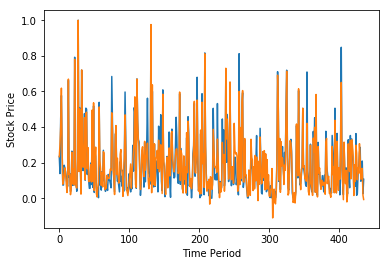

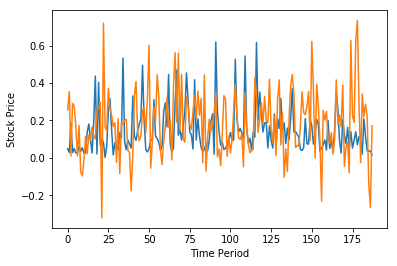

In [21]:
tf.reset_default_graph()

train_size = int(len(dataY)*0.7)
test_size = len(dataY) - train_size

trainX, testX = np.array(dataX[:train_size]), np.array(dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[:train_size]), np.array(dataY[train_size:len(dataY)])

X = tf.placeholder(tf.float32, [None, seq_len, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)
print(outputs[:, -1].shape)
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)

loss = tf.reduce_sum(tf.square(Y_pred - Y))
optimizer = tf.train.AdamOptimizer(0.02)
train = optimizer.minimize(loss)

targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess :
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in range(iterations) :
        _, step_loss = sess.run([train, loss], feed_dict = {X:trainX,Y:trainY})
        print("Step {} - loss : {}".format(i, step_loss))
        
    train_predict = sess.run(Y_pred, feed_dict = {X:trainX})
    train_rmse_val = sess.run(rmse, feed_dict = {targets : trainY, predictions : train_predict})
    print("RMSE : {}".format(train_rmse_val))
    test_predict = sess.run(Y_pred, feed_dict = {X:testX})
    rmse_val = sess.run(rmse, feed_dict = {targets : testY, predictions:test_predict})
    print("RMSE : {}".format(rmse_val))
    
    plt.plot(trainY)
    plt.plot(train_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

# Linear Model

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
num_lm_variables = seq_len * len(variable_list)
lm_trainX = np.reshape(trainX, (-1, num_lm_variables))
lm_trainY = np.reshape(trainY, (-1, 1))
lm_testX = np.reshape(testX, (-1, num_lm_variables))
lm_testY = np.reshape(testY, (-1, 1))

In [24]:
lm_trainX.shape

(436, 10)

In [25]:
lm = LinearRegression(fit_intercept=True, normalize=False, copy_X=True)
lm.fit(lm_trainX, lm_trainY)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
lm_train_pred = lm.predict(lm_trainX)
lm_test_pred = lm.predict(lm_testX)

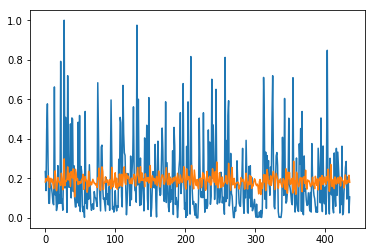

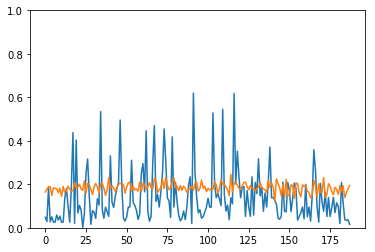

In [27]:
plt.plot(lm_trainY)
plt.plot(lm_train_pred)
plt.show()
    
plt.plot(lm_testY)
plt.plot(lm_test_pred)
plt.ylim(0, 1)
plt.show()

In [28]:
def rmse(target, pred):
    result = np.sqrt(np.mean(np.square(target - pred)))
    return result

In [29]:
train_rmse = rmse(lm_trainY, lm_train_pred)
test_rmse = rmse(lm_testY, lm_test_pred)
print(train_rmse)
print(test_rmse)

0.17876708961293747
0.12745337740301702


# Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [23]:
df.head()

,Date,KOSPI,KOSDAQ,Average_Temperature,Lowest_Temperature,Highest_temperature,Precipitation,Average_Wind_Speed,Average_Relative_humidity,Daylight_Hours,Cloud_Cover,Duration_of_Fog,Revenue,Fitness,Sports_Center,Gym,Diet,Body,Busan_Sports_Center,Busan_Gym
0,2016-01-04,1918.76,677.79,10.4,7.6,15.2,0.0,2.7,46.3,8.6,0.8,0.0,1200000,1.70885,0.66053,15.25185,69.49203,1.70459,74.50980,54.90196
1,2016-01-05,1930.53,684.07,5.3,3.2,8.1,0.2,3.1,40.9,0.0,7.0,0.0,900000,1.68328,0.54120,11.19918,58.96616,1.35089,20.91503,43.13725
2,2016-01-06,1925.43,687.27,4.8,1.8,9.9,0.0,2.9,34.5,7.7,5.6,0.0,950000,1.99437,0.45597,10.07841,62.38387,1.30827,25.49019,39.86928
3,2016-01-07,1904.33,679.66,3.9,1.1,8.5,0.0,2.7,47.3,8.6,0.9,0.0,880000,1.65771,0.47728,8.82553,63.78164,2.01142,22.87581,42.48366
4,2016-01-08,1917.62,682.56,2.5,-0.5,6.9,0.0,2.9,44.1,9.1,0.8,0.0,450000,1.35941,0.41336,7.26583,57.66641,1.44464,16.99346,24.83660


In [33]:
df.head()

,Date,KOSPI,KOSDAQ,Average_Temperature,Lowest_Temperature,Highest_temperature,Precipitation,Average_Wind_Speed,Average_Relative_humidity,Daylight_Hours,...,Duration_of_Fog,Revenue,Fitness,Sports_Center,Gym,Diet,Body,Busan_Sports_Center,Busan_Gym,Increasing_Rate
0,2016-01-04,1918.76,677.79,10.4,7.6,15.2,0.0,2.7,46.3,8.6,...,0.0,1200000,1.70885,0.66053,15.25185,69.49203,1.70459,74.50980,54.90196,0.000000
1,2016-01-05,1930.53,684.07,5.3,3.2,8.1,0.2,3.1,40.9,0.0,...,0.0,900000,1.68328,0.54120,11.19918,58.96616,1.35089,20.91503,43.13725,-0.250000
2,2016-01-06,1925.43,687.27,4.8,1.8,9.9,0.0,2.9,34.5,7.7,...,0.0,950000,1.99437,0.45597,10.07841,62.38387,1.30827,25.49019,39.86928,0.055556
3,2016-01-07,1904.33,679.66,3.9,1.1,8.5,0.0,2.7,47.3,8.6,...,0.0,880000,1.65771,0.47728,8.82553,63.78164,2.01142,22.87581,42.48366,-0.073684
4,2016-01-08,1917.62,682.56,2.5,-0.5,6.9,0.0,2.9,44.1,9.1,...,0.0,450000,1.35941,0.41336,7.26583,57.66641,1.44464,16.99346,24.83660,-0.488636


,Date,KOSPI,KOSDAQ,Average_Temperature,Lowest_Temperature,Highest_temperature,Precipitation,Average_Wind_Speed,Average_Relative_humidity,Daylight_Hours,...,Revenue,Fitness,Sports_Center,Gym,Diet,Body,Busan_Sports_Center,Busan_Gym,Increasing_Rate,Rate_Class
0,2016-01-04,0.115513,0.459785,0.388889,0.438692,0.412281,0.000000,0.010223,0.461224,0.089304,...,0.255834,0.293963,0.110771,0.992950,0.646212,0.432920,0.767606,0.951220,0.006933,moderate
1,2016-01-05,0.131799,0.487909,0.239766,0.318801,0.204678,0.001675,0.011738,0.406122,0.000000,...,0.191608,0.286088,0.082052,0.657737,0.515434,0.339347,0.190141,0.731707,0.005147,moderate
2,2016-01-06,0.124742,0.502239,0.225146,0.280654,0.257310,0.000000,0.010981,0.340816,0.079958,...,0.202312,0.381889,0.061539,0.565034,0.557897,0.328071,0.239437,0.670732,0.007329,moderate
3,2016-01-07,0.095546,0.468159,0.198830,0.261580,0.216374,0.000000,0.010223,0.471429,0.089304,...,0.187326,0.278214,0.066667,0.461403,0.575263,0.514093,0.211268,0.719512,0.006406,moderate
4,2016-01-08,0.113935,0.481146,0.157895,0.217984,0.169591,0.000000,0.010981,0.438776,0.094496,...,0.095269,0.186352,0.051283,0.332393,0.499285,0.364149,0.147887,0.390244,0.003443,low


In [40]:
dataX = []
dataY = []
for i in range(df_subset_scaled.shape[0] - seq_len):
    _x = df_subset_scaled.loc[i:i+seq_len-1, variable_list].values
    _y = df_subset_scaled.loc[i+seq_len, ['Rate_Class']].values
    dataX.append(_x)
    dataY.append(_y)

train_size = int(len(dataY)*0.7)
test_size = len(dataY) - train_size

trainX, testX = np.array(dataX[:train_size]), np.array(dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[:train_size]), np.array(dataY[train_size:len(dataY)])

num_lm_variables = seq_len * len(variable_list)
dt_trainX = np.reshape(trainX, (-1, num_lm_variables))
dt_trainY = np.reshape(trainY, (-1, 1))
dt_testX = np.reshape(testX, (-1, num_lm_variables))
dt_testY = np.reshape(testY, (-1, 1))

In [41]:
print(dt_trainX)
print(dt_trainY)

[[0.38888889 0.25583387 0.23976608 ... 0.18732605 0.15789474 0.09526868]
 [0.23976608 0.19160779 0.2251462  ... 0.09526868 0.19590643 0.23442518]
 [0.2251462  0.20231214 0.19883041 ... 0.23442518 0.21637427 0.13808606]
 ...
 [0.64035088 0.18090345 0.60233918 ... 0.09526868 0.64619883 0.13808606]
 [0.60233918 0.25583387 0.60233918 ... 0.13808606 0.73976608 0.20873475]
 [0.60233918 0.28580604 0.60233918 ... 0.20873475 0.7251462  0.02526226]]
[['very high']
 ['low']
 ['very high']
 ['moderate']
 ['low']
 ['very low']
 ['moderate']
 ['very high']
 ['moderate']
 ['moderate']
 ['moderate']
 ['low']
 ['moderate']
 ['very high']
 ['very low']
 ['moderate']
 ['very low']
 ['high']
 ['very high']
 ['very low']
 ['very high']
 ['low']
 ['very high']
 ['very low']
 ['moderate']
 ['low']
 ['very high']
 ['very high']
 ['very low']
 ['very high']
 ['low']
 ['very low']
 ['very high']
 ['very low']
 ['low']
 ['very high']
 ['very high']
 ['very low']
 ['very high']
 ['moderate']
 ['very low']
 ['very

In [42]:
dt = DecisionTreeClassifier()
dt.fit(dt_trainX, dt_trainY)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [43]:
pred_y = dt.predict(dt_testX)
true_y = dt_testY.reshape((-1))

In [44]:
confusion_matrix(true_y, pred_y)

array([[ 4,  1,  0, 10,  3],
       [ 3, 10, 11,  9,  7],
       [ 1,  6, 10, 14, 10],
       [ 5,  7, 15, 25,  4],
       [ 3,  7,  7,  3, 13]])

array([['very high'],
       ['low'],
       ['very high'],
       ['moderate'],
       ['low'],
       ['very low'],
       ['moderate'],
       ['very high'],
       ['moderate'],
       ['moderate'],
       ['moderate'],
       ['low'],
       ['moderate'],
       ['very high'],
       ['very low'],
       ['moderate'],
       ['very low'],
       ['high'],
       ['very high'],
       ['very low'],
       ['very high'],
       ['low'],
       ['very high'],
       ['very low'],
       ['moderate'],
       ['low'],
       ['very high'],
       ['very high'],
       ['very low'],
       ['very high'],
       ['low'],
       ['very low'],
       ['very high'],
       ['very low'],
       ['low'],
       ['very high'],
       ['very high'],
       ['very low'],
       ['very high'],
       ['moderate'],
       ['very low'],
       ['very high'],
       ['very low'],
       ['low'],
       ['moderate'],
       ['very high'],
       ['very low'],
       ['very high'],
       ['very low']

# Save to excel

In [34]:
import openpyxl

In [35]:
df.to_excel('df.xlsx', sheet_name='sheet1', index=False)
df_subset_scaled.to_excel('scaled_df.xlsx', sheet_name='sheet1', index=False)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/io/excel.py:784: DeprecationWarning: Call to deprecated function remove_sheet (Use wb.remove(worksheet) or del wb[sheetname]).
  self.book.remove_sheet(self.book.worksheets[0])
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-05-30 19:55:40.124812. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [112]:
np.array(df['Rate_Class'])

array(['moderate', 'moderate', 'moderate', 'moderate', 'low', 'very high',
       'low', 'very high', 'moderate', 'low', 'very low', 'moderate',
       'very high', 'moderate', 'moderate', 'moderate', 'low', 'moderate',
       'very high', 'very low', 'moderate', 'very low', 'high',
       'very high', 'very low', 'very high', 'low', 'very high',
       'very low', 'moderate', 'low', 'very high', 'very high',
       'very low', 'very high', 'low', 'very low', 'very high',
       'very low', 'low', 'very high', 'very high', 'very low',
       'very high', 'moderate', 'very low', 'very high', 'very low',
       'low', 'moderate', 'very high', 'very low', 'very high',
       'very low', 'very high', 'very low', 'very high', 'moderate',
       'very low', 'low', 'very high', 'very low', 'very high',
       'very low', 'very high', 'very low', 'very high', 'low',
       'very high', 'low', 'low', 'low', 'very high', 'moderate', 'low',
       'very high', 'moderate', 'moderate', 'moderate', 

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-05-11 01:06:29.713108. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [124]:
df['Rate_Class'].value_counts()

very high    196
very low     138
moderate     132
low          124
high          39
Name: Rate_Class, dtype: int64

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-05-11 01:14:07.375068. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)
